In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import math
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from itertools import islice
import plotly.graph_objects as go
from typing import List, Generator
from datetime import datetime, timedelta

In [3]:
def gen_gbm(period: float, start_amount: float, drift: float, volatility: float) -> Generator[float, None, None]:
    current_amt = start_amount
    i = 1
    while(True):
        c = (current_amt * drift * period) + \
            (current_amt * volatility * np.random.normal(0, math.sqrt(period))) + \
            math.cos(2 * math.pi * i * period) + .25
        yield current_amt + c
        current_amt += c
        i += 1

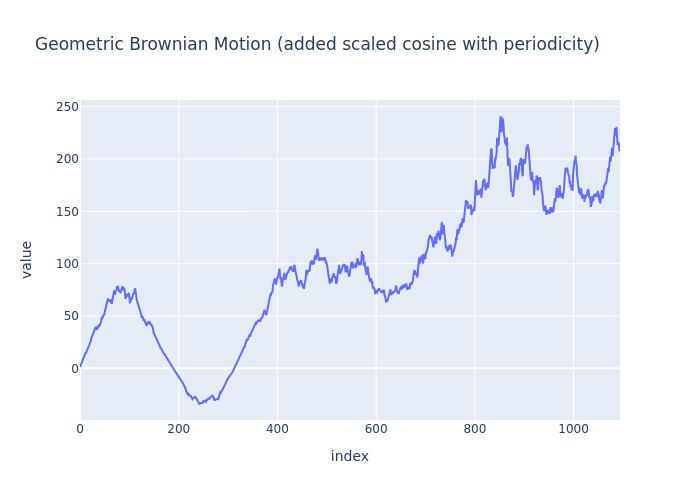

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=list(islice(gen_gbm((1/365.), 0, .01, .6), 365*3)), mode='lines', name='Actual'))
fig.update_layout(title=f'Geometric Brownian Motion (added scaled cosine with periodicity)', xaxis_title='index', yaxis_title='value')
fig.show(renderer="png")

In [5]:
def generate_df(total: int, start_amts: List[float], drift: float, volatility: float, 
                end_date: datetime=datetime.now(), output_dir=None):
     # current items
    current_date = end_date - timedelta(days=total)
    
    # generators
    gen = [gen_gbm(period=1/365., 
                   start_amount=start_amts[i], 
                   drift=drift, 
                   volatility=volatility)
                        for i in range(len(start_amts))]

    # empty dataframe
    cols = ['date', 'resource_id', 'earnings']
    df = pd.DataFrame(columns=cols)

    for i in range(total):
        # generate for each
        r = [(current_date.strftime('%Y-%m-%d'), j+1, next(gen[j])) 
                    for j in range(len(gen))]

        # add rows
        df = df.append(pd.DataFrame(r, columns=cols))

        # increment vals
        current_date = current_date + timedelta(days=1)

    # save file if requested
    if output_dir != None:
        output_dir = Path(output_dir).resolve()
        if not output_dir.exists():
            os.makedirs(str(output_dir))
        curds = datetime.now().strftime("%m.%d.%H.%M.%S")
        startds = (end_date - timedelta(days=total)).strftime("%y.%m.%d")
        file_path = f'D{startds}G{curds}.parquet'
        df.to_parquet(output_dir / file_path)

    return df

In [6]:
years = 10
args = {
    'total': 365 * years,
    'start_amts': [200000., 143320, 83420, 50000, 40000],
    'drift': .01,
    'volatility': .4,
    'end_date': datetime.now(),
    'output_dir': '../data'
}
data = generate_df(**args)

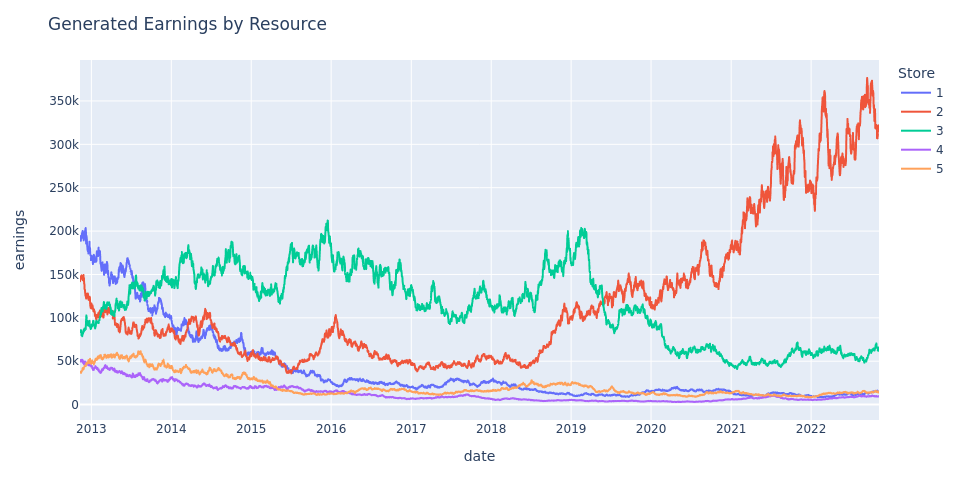

In [7]:
fig = px.line(data, x="date", y="earnings", color='resource_id')
fig.update_layout(title=f'Generated Earnings by Resource', xaxis_title='date',
                  yaxis_title='earnings', legend_title='Store', width=960)
fig.show(renderer="png")


In [8]:
agg_data = data.groupby(by=['date']).sum()
agg_data.sort_values(by=['date'])

,earnings
date,
2012-11-10,508389.690902
2012-11-11,511884.616433
2012-11-12,511271.567579
2012-11-13,512738.280198
2012-11-14,507685.968186
...,...
2022-11-03,415308.125622
2022-11-04,415899.025322
2022-11-05,422655.661357


In [ ]:
data.loc[data['resource_id'] == 1].drop(columns=['resource_id'])